# Nucleation & Gas Phase Depletion Experiments

In [1]:
import numpy as np
from matplotlib.pyplot import *
from jupyterthemes import jtplot
from IPython.display import set_matplotlib_formats

## Time-dependant nucleation

The goal of this experiment is to see if we can simulate the depletion of the H2O gas phase. To do that, we calculate both the nucleaation rate (number of new clusters per unit volume each second), and the number of molecules in a new cluster ($i^*$, size of the critical cluster in Seinfeld).

Since we have both these numbers, we know how many molecules were "taken" from the gas phase for each time frame, and we can compute a new $p_{\text{H}_{2}\text{O}}$ for the next step.

*One potential issue is that nucleation releases energy as latent heat, which changes the ambiant temperature. This does not account for that.*

In [2]:
%matplotlib inline
set_matplotlib_formats('svg')
jtplot.style(theme='oceans16', context='notebook', ticks=True)
rcParams['figure.figsize'] = [10, 3]

sigma = 72.75e-3 # Converted into SI
dalton = 1.66053906660e-27
m1 = 18.02 * dalton #m1 = 2.99e-23 * 1e-3# Converted into SI
v1 = 2.99e-23 * 1e-6 # converted into SI
kb = 1.38e-23

# Tetens equation
# https://en.wikipedia.org/wiki/Vapour_pressure_of_water
def p_sat(t):
    t -= 273
    return 610.78 * np.exp((17.27 * t) / (237.3 + t))

## Equations from Seinfeld

In [3]:
def cluster(t, p_h2o):
    S = p_h2o / p_sat(t)
    return (32.0 * np.pi / 3.0) \
         * ((v1**2.0) * (sigma ** 3.0))/(((kb * t)**3.0) * (np.log(S)**3.0))

def nucleate(t, p_h2o):
    N = p_h2o / (kb * t)
    S = p_h2o / p_sat(t)
    inside = - (16.0 * np.pi / 3.0) \
             * ((v1**2.0) * (sigma**3.0)) \
             / (((kb*t)**3.0) * (np.log(S)**2.0))
    return np.sqrt(2.0 * sigma / (np.pi * m1)) \
         * (v1 * (N**2.0) / S) \
         * np.exp(inside)

In [4]:
t = 293
S = np.linspace(2, 10)
p_h2o = S * p_sat(t)

## Size of the critical cluster (number of molecules in a single droplet)

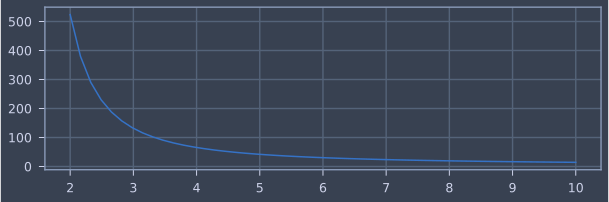

In [5]:
i_s = cluster(t, p_h2o)
plot(S, i_s)
show()

This curve is consistent with the table pp.502;503;509 of Seinfeld. This gives us the cluster size above which we see nucleation.

 ## Nucleation Rate

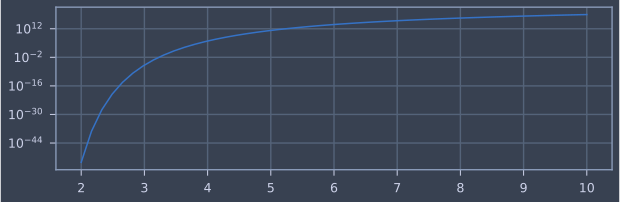

In [6]:
J = nucleate(t, p_h2o)
semilogy(S, J * 1e-6) # To convert to CGS to compare with the data from Seinfeld, p 509
show()

## Depletion of the gas phase

$J$ gives us the number of new clusters that have nucleated in a unit volume in a second. Since $i^*$ gives us the size of one of these critical clusters (in number of molecules), $J i^* \Delta t$ gives us the amount of molecules taken from the gas phase in a length of time $\Delta t$. We can recover the new partial pressure from that, and use an iterative method (here, basic Euler) to compute the evolution of the number of cloud particles over time.

In [7]:
Nd = 0
S = 7
t = 293
p_h2o = S * p_sat(t)
N = p_h2o / (kb * t)

tau = 0
dtau = 1.0

Js = []
Nds = []
Ns = []
ps = []
taus = []

for _ in range(0, 1000):
    
    Ns.append(N)
    Nds.append(Nd)
    ps.append(p_h2o)
    
    J = nucleate(t, p_h2o)
    i = cluster(t, p_h2o)
    
    Nd += J * dtau
    N -= J * i * dtau
    p_h2o = N * kb * t
    
    Js.append(J)
    taus.append(tau)
    tau += dtau

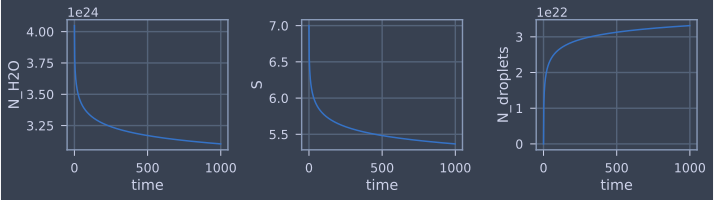

In [8]:
f = figure()
subplot(1, 3, 1)
plot(taus, Ns)
xlabel('time')
ylabel('N_H2O')
subplot(1, 3, 2)
plot(taus, ps/p_sat(t))
xlabel('time')
ylabel('S')
subplot(1, 3, 3)
plot(taus, Nds)
xlabel('time')
ylabel('N_droplets')
f.tight_layout()
show()

**Nucleation, and therefore depletion follows an exponential curve which makes sense given the formula. We seem to get poor nucleation if $S < 5.5$**